In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from fbprophet import Prophet

In [4]:
missing_values=["n/a","na","--","?"]
df=pd.read_csv('../../dataproject/train.csv', na_values=missing_values)
#dftest=pd.read_csv('../../dataproject/test.csv', na_values=missing_values)

In [5]:
df_store1 =df[(df['store']==1)&(df['item']==1)]
#df_store1

In [6]:
df = df_store1[['date','sales']]

In [7]:
df.columns = ['ds','y']
df.head()

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [8]:
df.ds = pd.to_datetime(df.ds)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1826 non-null   datetime64[ns]
 1   y       1826 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.8 KB


In [10]:
#train = df.iloc[:len(df)-92] 
#test = df.iloc[len(df)-92:] # set 3 months(92 days)) for testing

In [11]:
## EXOGENOUS FOR ITEMS MORE THAN 25
def y_more25(y):
    #date = pd.to_datetime(ds)
    if y >25:
        return 1
    else:
        return 0
df['y_25'] = df['y'].apply(y_more25)

In [12]:
df.tail()

,ds,y,y_25
1821,2017-12-27,14,0
1822,2017-12-28,19,0
1823,2017-12-29,15,0
1824,2017-12-30,27,1
1825,2017-12-31,23,0


In [13]:
train = df.iloc[:len(df)-92] 
test = df.iloc[len(df)-92:] # set 3 months(92 days)) for testing

In [14]:
m = Prophet(yearly_seasonality=False, 
                    weekly_seasonality=False, 
                    daily_seasonality=False,
                    seasonality_mode='multiplicative'
                   ).add_seasonality(name = 'weekly', 
                                      period = 7, 
                                      fourier_order = 25
                    ).add_seasonality(name = 'yearly', 
                                      period = 365.25,
                                      fourier_order = 10
                    ).add_seasonality(name = 'monthly', 
                                      period = 30.5, 
                                      fourier_order = 15
                    ).add_seasonality(name = 'quarterly', 
                                       period = 365.25 / 4, 
                                       fourier_order = 7,
                    ).add_seasonality(name = 'biweekly', 
                                       period = 14, 
                                       fourier_order = 10,
                    ).add_seasonality(name = '3week', 
                                       period = 21, 
                                       fourier_order = 5
                    )
m.add_country_holidays(country_name='US')

In [15]:
m.add_regressor('y_25', prior_scale=0.5, mode='multiplicative')

In [16]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [17]:
future = m.make_future_dataframe(periods=len(test))
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [18]:
future

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1821,2017-12-27
1822,2017-12-28
1823,2017-12-29
1824,2017-12-30


In [19]:
future['y_25']=df['y_25']

In [20]:
future

,ds,y_25
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0
...,...,...
1821,2017-12-27,0
1822,2017-12-28,0
1823,2017-12-29,0
1824,2017-12-30,1


In [21]:
forecast = m.predict(future)


In [35]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,3week,3week_lower,3week_upper,Christmas Day,...,y_25,y_25_lower,y_25_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,13.362875,6.847843,15.878543,13.362875,13.362875,0.019724,0.019724,0.019724,0.0,...,0.000000,0.000000,0.000000,-0.257867,-0.257867,-0.257867,0.0,0.0,0.0,11.311232
1,2013-01-02,13.367939,7.698980,16.492966,13.367939,13.367939,0.011482,0.011482,0.011482,0.0,...,0.000000,0.000000,0.000000,-0.260061,-0.260061,-0.260061,0.0,0.0,0.0,11.790933
2,2013-01-03,13.373003,7.670424,16.569902,13.373003,13.373003,0.008691,0.008691,0.008691,0.0,...,0.000000,0.000000,0.000000,-0.262830,-0.262830,-0.262830,0.0,0.0,0.0,12.295148
3,2013-01-04,13.378067,7.701422,16.734085,13.378067,13.378067,0.024151,0.024151,0.024151,0.0,...,0.000000,0.000000,0.000000,-0.266075,-0.266075,-0.266075,0.0,0.0,0.0,12.208290
4,2013-01-05,13.383132,9.754989,18.218708,13.383132,13.383132,0.033316,0.033316,0.033316,0.0,...,0.000000,0.000000,0.000000,-0.269683,-0.269683,-0.269683,0.0,0.0,0.0,13.852644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,16.878228,8.553201,17.310549,16.862954,16.894274,-0.026354,-0.026354,-0.026354,0.0,...,0.000000,0.000000,0.000000,-0.257799,-0.257799,-0.257799,0.0,0.0,0.0,13.003413
1822,2017-12-28,16.877605,10.159229,19.045800,16.861948,16.893858,-0.020772,-0.020772,-0.020772,0.0,...,0.000000,0.000000,0.000000,-0.256286,-0.256286,-0.256286,0.0,0.0,0.0,14.600263
1823,2017-12-29,16.876983,10.459783,19.212485,16.861237,16.893441,-0.014999,-0.014999,-0.014999,0.0,...,0.000000,0.000000,0.000000,-0.255472,-0.255472,-0.255472,0.0,0.0,0.0,14.684450
1824,2017-12-30,16.876360,20.789091,29.565429,16.860215,16.892985,-0.013833,-0.013833,-0.013833,0.0,...,0.490112,0.490112,0.490112,-0.255391,-0.255391,-0.255391,0.0,0.0,0.0,25.106726


In [22]:
#forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [37]:
predict = forecast[['ds', 'yhat']]
predict= predict.set_index('ds')
predict = predict.iloc[len(predict)-92:]

In [38]:
predict

,yhat
ds,
2017-10-01,20.652185
2017-10-02,17.074962
2017-10-03,18.135811
2017-10-04,19.166719
2017-10-05,19.238957
...,...
2017-12-27,13.003413
2017-12-28,14.600263
2017-12-29,14.684450


In [42]:
test=test[['ds', 'y']]
test=test.set_index('ds')
test

,y
ds,
2017-10-01,21
2017-10-02,12
2017-10-03,18
2017-10-04,15
2017-10-05,20
...,...
2017-12-27,14
2017-12-28,19
2017-12-29,15


In [43]:
compare = pd.concat([predict, test], axis = 1)
compare.columns = ['Prediction', 'Actual']

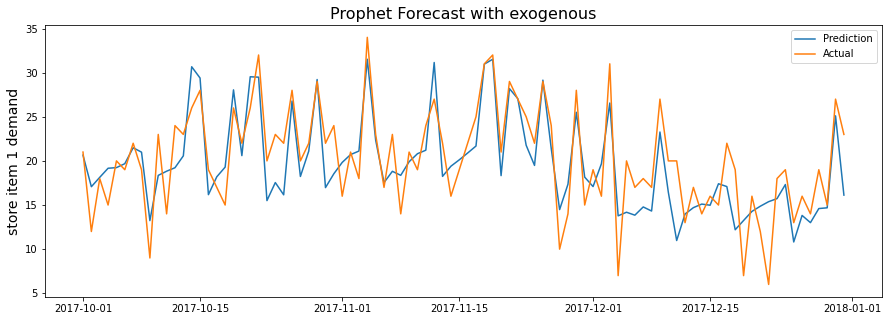

In [44]:
plt.figure(figsize = (15,5))
plt.plot(compare)
plt.title('Prophet Forecast with exogenous', fontsize = 16)
plt.ylabel('store item 1 demand', fontsize = 14)
plt.legend(compare.columns)
plt.show()

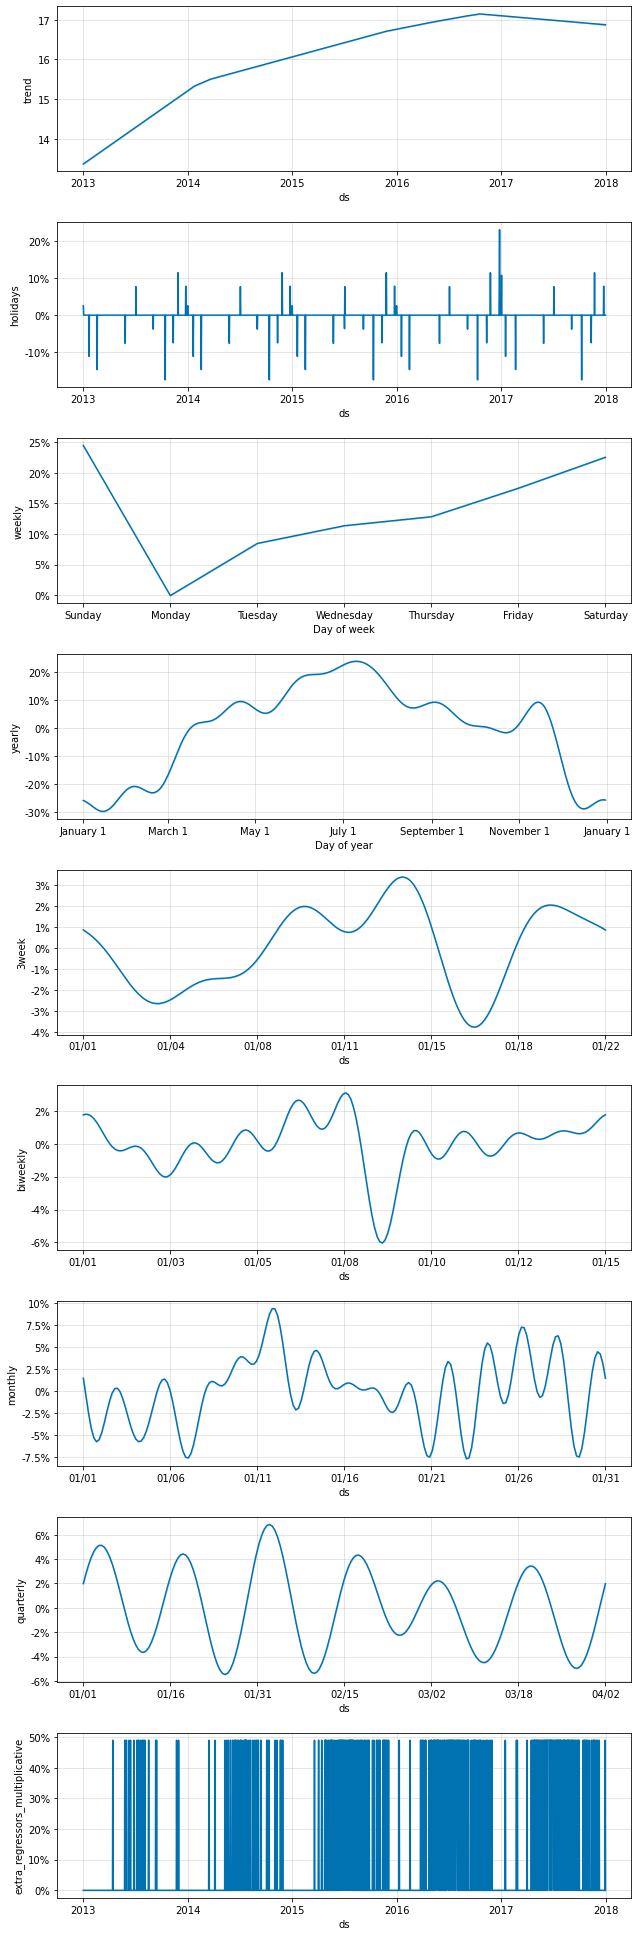

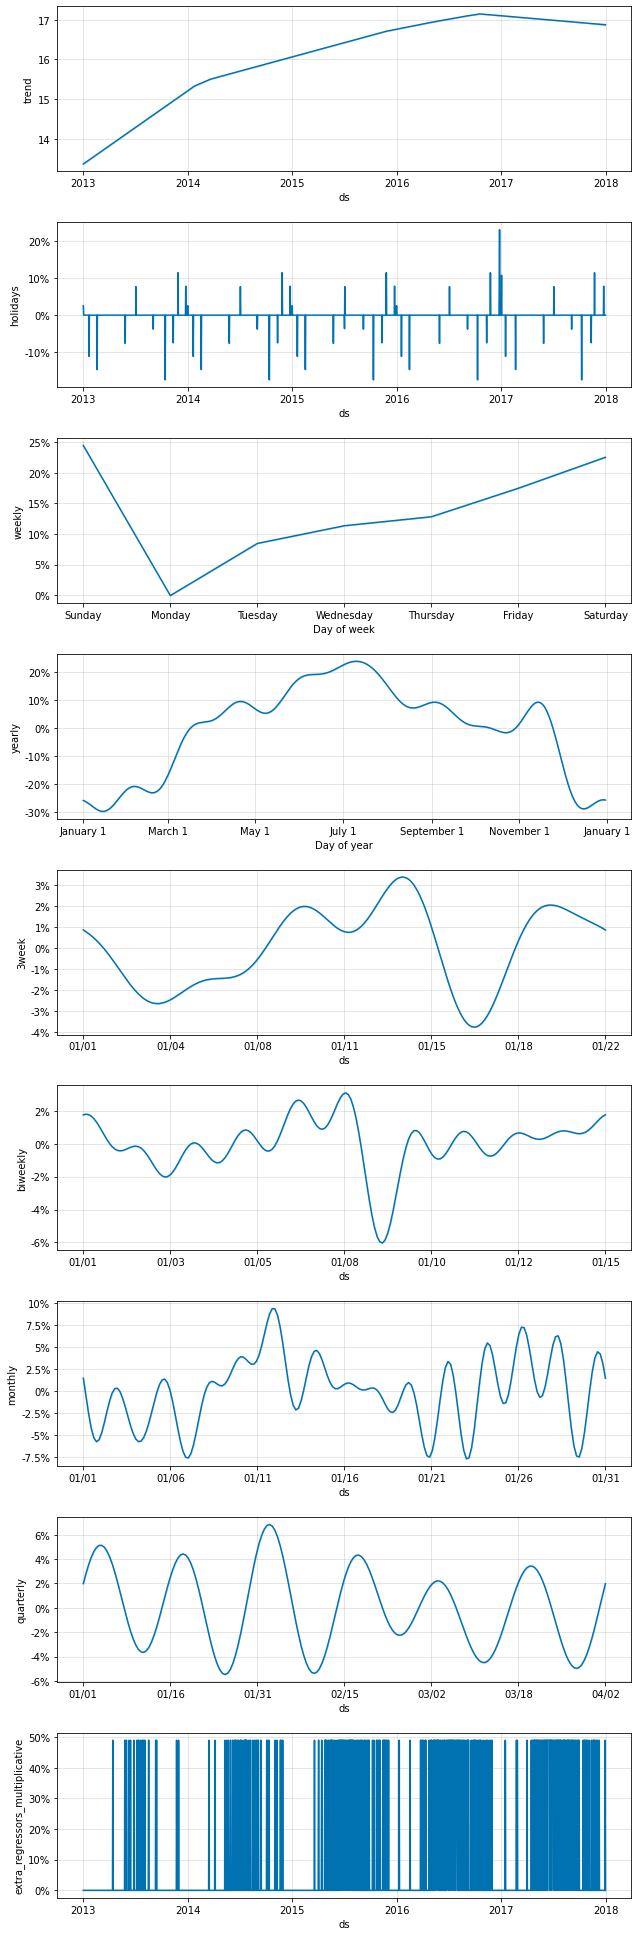

In [23]:
m.plot_components(forecast)

In [45]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))
    print('RMSE: {}'.format(sqrt(mean_squared_error(y_true, y_pred))))

In [46]:
print('Prophet')
regPrintErr(compare['Actual'], compare['Prediction'])

Prophet
R2 Score: 0.6345687552988032
MAPE: 16.60832040729678
RMSE: 3.520469572440219
